In [1]:
%cd ..

import pandas as pd
import numpy as np
import shap
from scripts.utils import *

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split

pd.set_option('display.max_columns', None)

/run/media/nazif/2F946E411BA61D49/thesis


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
cols_to_keep = [
    "pred_energy",
    "pred_num_basepairs",
    "pred_seed_basepairs",
    "ta_log10",
    "sps_mean",
    "anchor_a",
    "6mer_seed",
    "match_8",
    "6mer_seed_1_mismatch",
    "compensatory_site",
    "supplementary_site",
    "supplementary_site_2",
    "empty_seed",
    "9_consecutive_match_anywhere",
    "mirna_conservation",
    "seed_8mer",
    "seed_7mer_a1",
    "seed_7mer_m8",
    "seed_compensatory",
    "seed_clash_2",
    "seed_clash_3",
    "seed_clash_4",
    "seed_clash_5",
    "mre_au_content",
    "local_au_content",
    # "another_mre_in_close_proximity",
    # "position_of_mre_in_transcript",
    "label"
]
df = pd.read_csv("results/5_generate_features.csv", usecols=cols_to_keep)


# train test split

In [3]:
X = df.drop("label", axis=1)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# fitting model

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


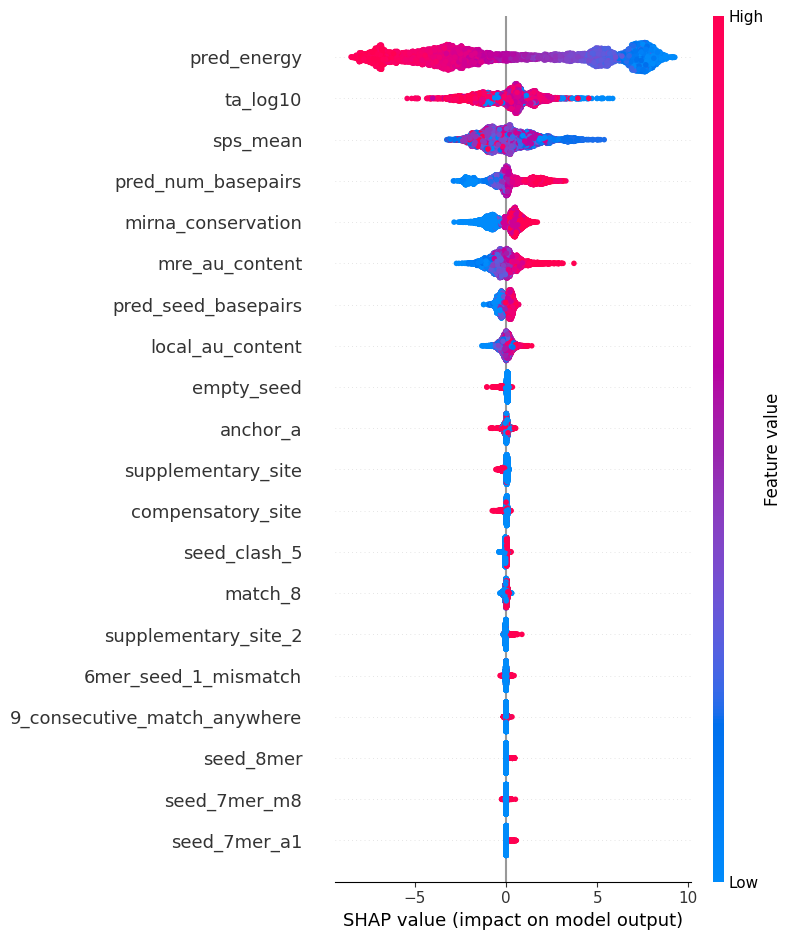

In [4]:
model = XGBClassifier()

model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)



In [5]:
report_performance(model, X_test, y_test)

{'Accuracy': 0.9854721549636803,
 'Precision': 0.9852142426071213,
 'Recall': 0.9840265220012056,
 'F1-Score': 0.9846200241254524,
 'ROC AUC': 0.9853970039117559}

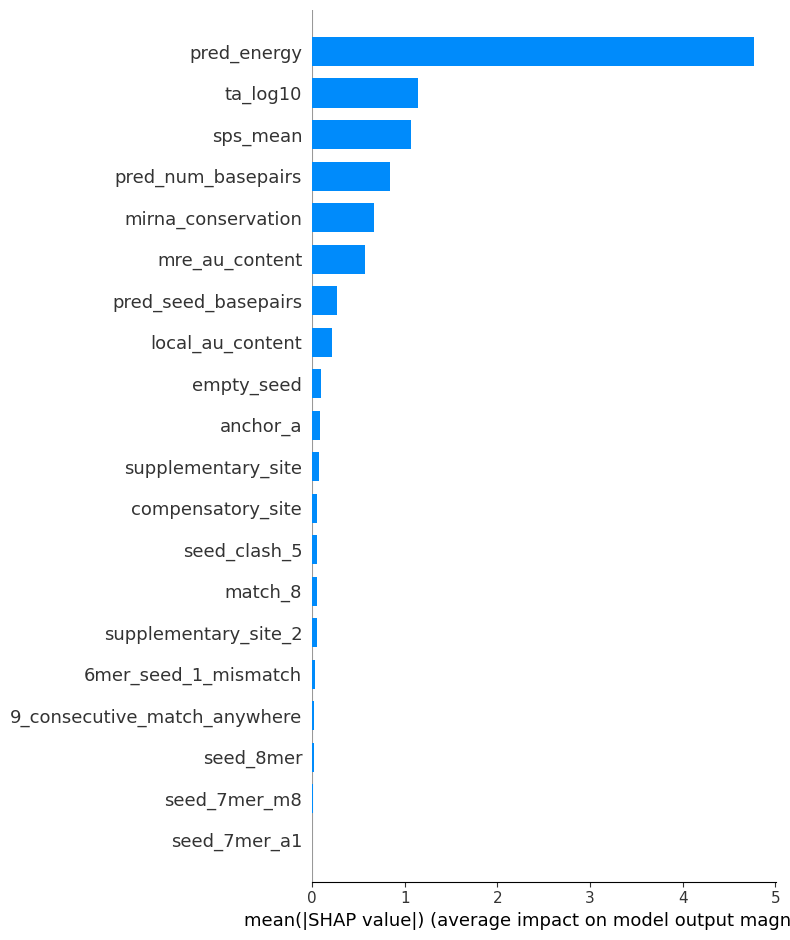

In [6]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


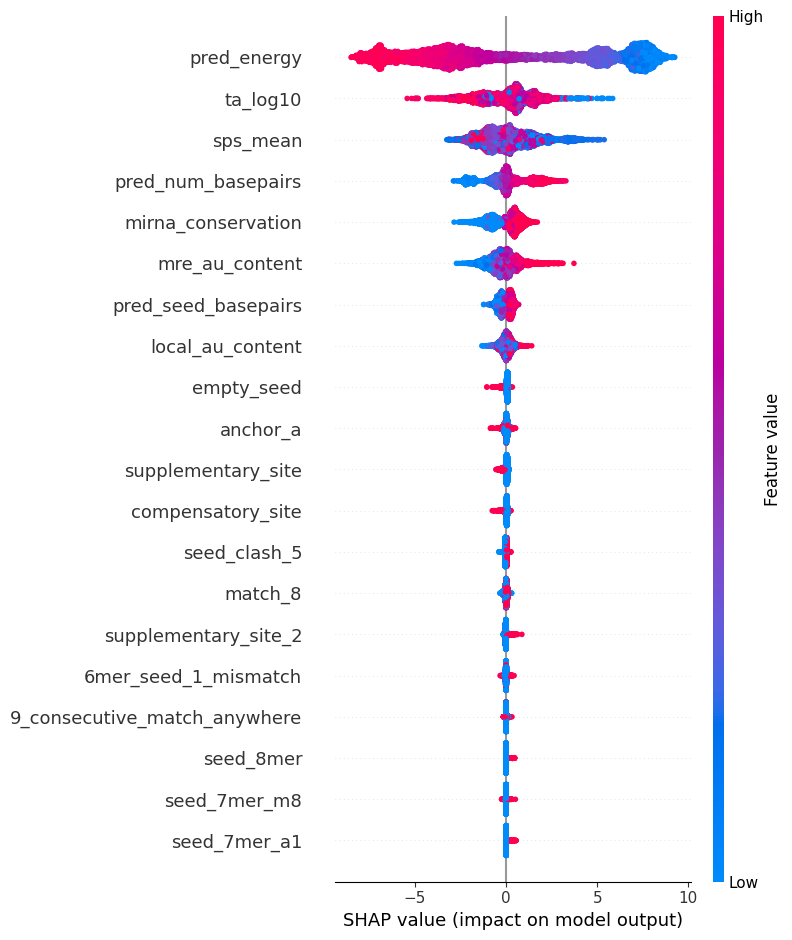

In [7]:
shap.summary_plot(shap_values, X_test)


In [8]:
# col_drop_results = drop_column_and_score(X, y)


In [9]:
# def stylize_df(df, base_intensity=0.05, difference_intensity=0.8):
#     # Define a function to apply color based on cell values
#     def apply_color(row):
#         color = []  # List to store color values for each cell in the row
#         for i, cell in enumerate(row):
#             # Check if the cell value is equal to the first cell value in the DataFrame
#             if cell == df.iloc[0, i]:
#                 color.append('background-color: black')  # If equal, set background color to black
#             else:
#                 # Calculate the difference between the cell value and the first cell value
#                 diff = cell - df.iloc[0, i]
#                 # Calculate the maximum difference in the DataFrame
#                 max_diff = df.values.max() - df.values.min()
#                 if diff > 0:
#                     # If the difference is positive, calculate the intensity of green color based on the difference
#                     intensity = min(1.0, base_intensity + difference_intensity * (diff / max_diff))
#                     color.append(f'background-color: rgba(0, 255, 0, {intensity:.2f})')  # Green with intensity
#                 else:
#                     # If the difference is negative, calculate the intensity of red color based on the difference
#                     intensity = min(1.0, base_intensity - difference_intensity * (diff / max_diff))
#                     color.append(f'background-color: rgba(255, 0, 0, {intensity:.2f})')  # Red with intensity
#         return color

#     # Apply the color function to each row of the DataFrame using the `.style.apply()` method
#     return df.style.apply(apply_color, axis=1)

# stylized_df = stylize_df(col_drop_results, base_intensity=0.05, difference_intensity=0.8)
# stylized_df

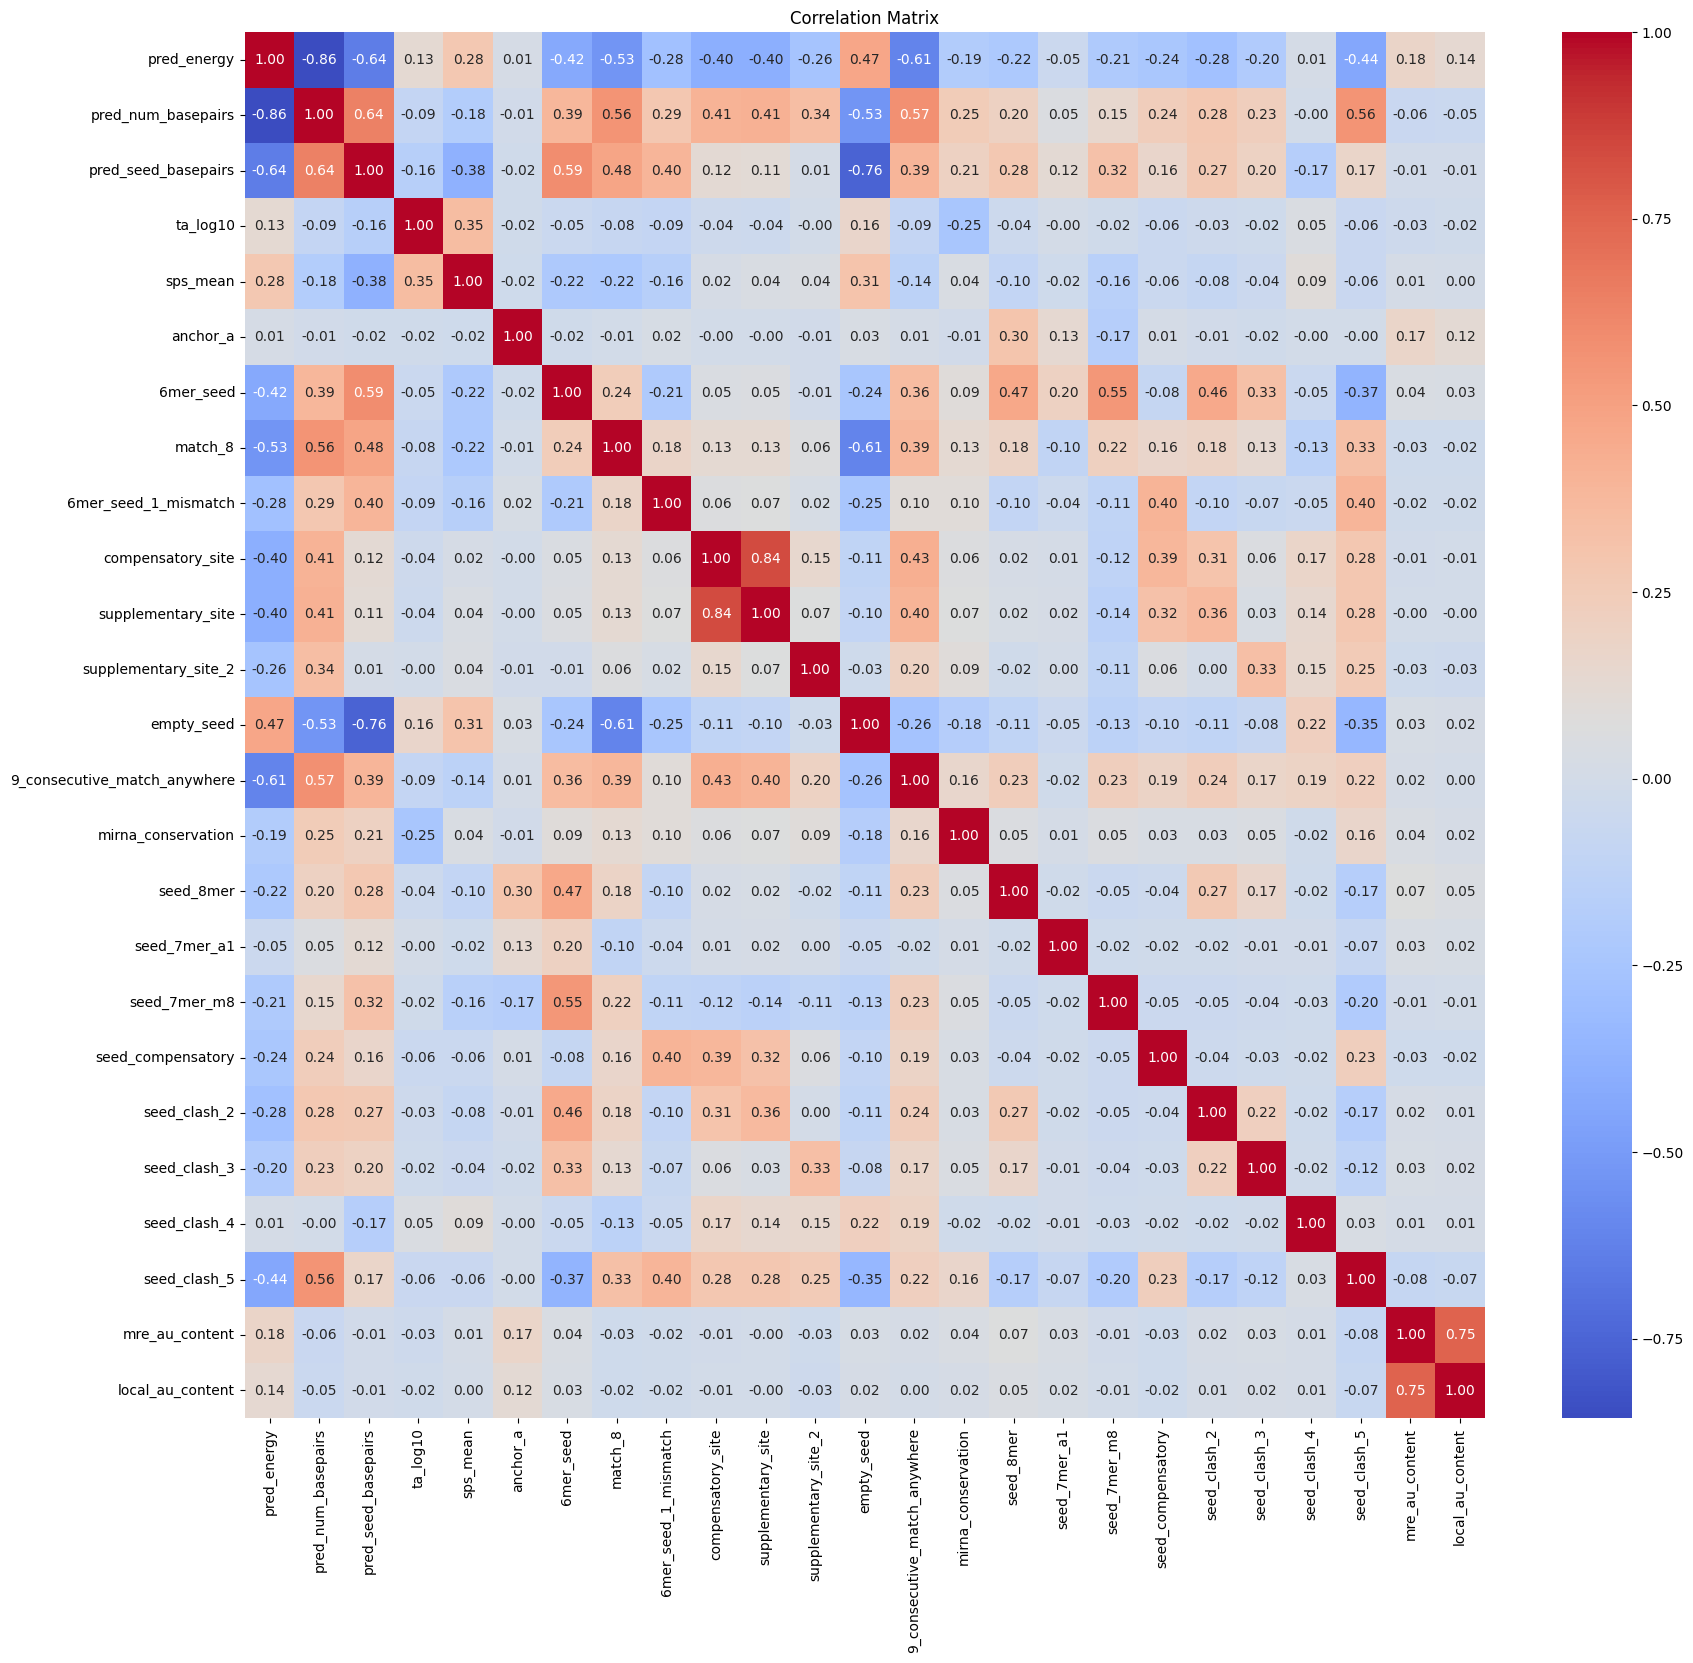

In [10]:
correlation_matrix = X.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [11]:
find_most_correlated_features(X)


pred_num_basepairs            pred_energy            0.856427
supplementary_site            compensatory_site      0.835572
empty_seed                    pred_seed_basepairs    0.759889
local_au_content              mre_au_content         0.753771
pred_seed_basepairs           pred_num_basepairs     0.644311
                              pred_energy            0.641548
9_consecutive_match_anywhere  pred_energy            0.612931
empty_seed                    match_8                0.609990
6mer_seed                     pred_seed_basepairs    0.589919
9_consecutive_match_anywhere  pred_num_basepairs     0.573359
match_8                       pred_num_basepairs     0.563854
seed_clash_5                  pred_num_basepairs     0.560215
seed_7mer_m8                  6mer_seed              0.548794
match_8                       pred_energy            0.534410
empty_seed                    pred_num_basepairs     0.530931
dtype: float64

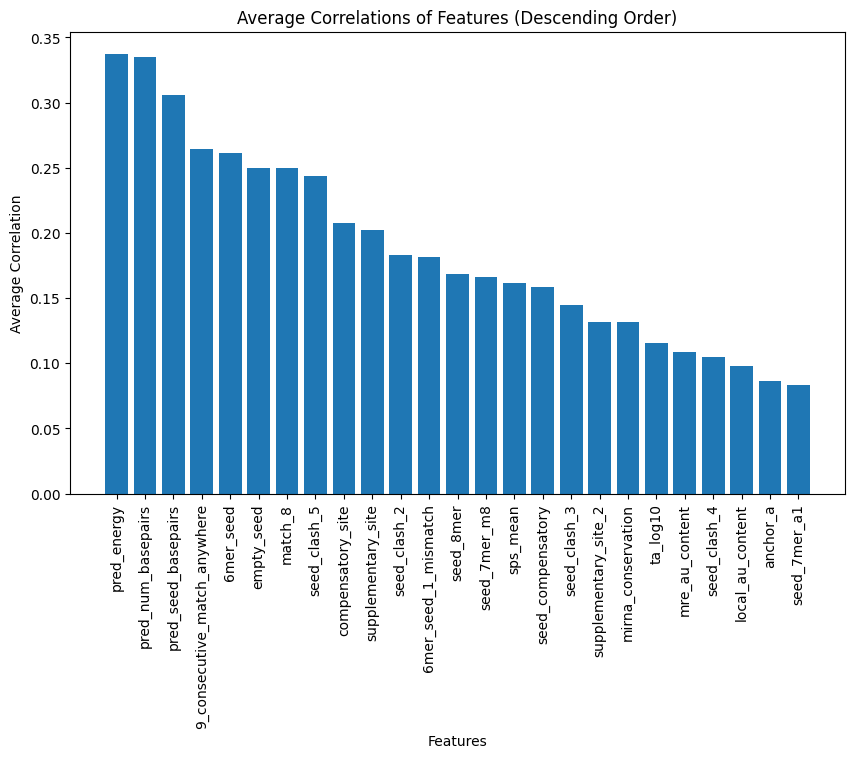

In [12]:
avgcorr = get_average_correlations(X)

avgcorr = avgcorr.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(avgcorr.index, avgcorr.values)
plt.xlabel('Features')
plt.ylabel('Average Correlation')
plt.title('Average Correlations of Features (Descending Order)')
plt.xticks(rotation=90)
plt.show()

In [13]:
model_after_cv = XGBClassifier(
    learning_rate=0.2,
    n_estimators=300,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0
)



model_after_cv.fit(X_train, y_train)

explainer = shap.TreeExplainer(model_after_cv)
shap_values_after_cv = explainer.shap_values(X_test)
shap_explanation = shap.Explanation(values=shap_values_after_cv, base_values=explainer.expected_value, data=X_test)

report_performance(model_after_cv, X_test, y_test)

{'Accuracy': 0.9864691639367611,
 'Precision': 0.9861236802413273,
 'Recall': 0.9852320675105485,
 'F1-Score': 0.9856776722448364,
 'ROC AUC': 0.9864048536310506}

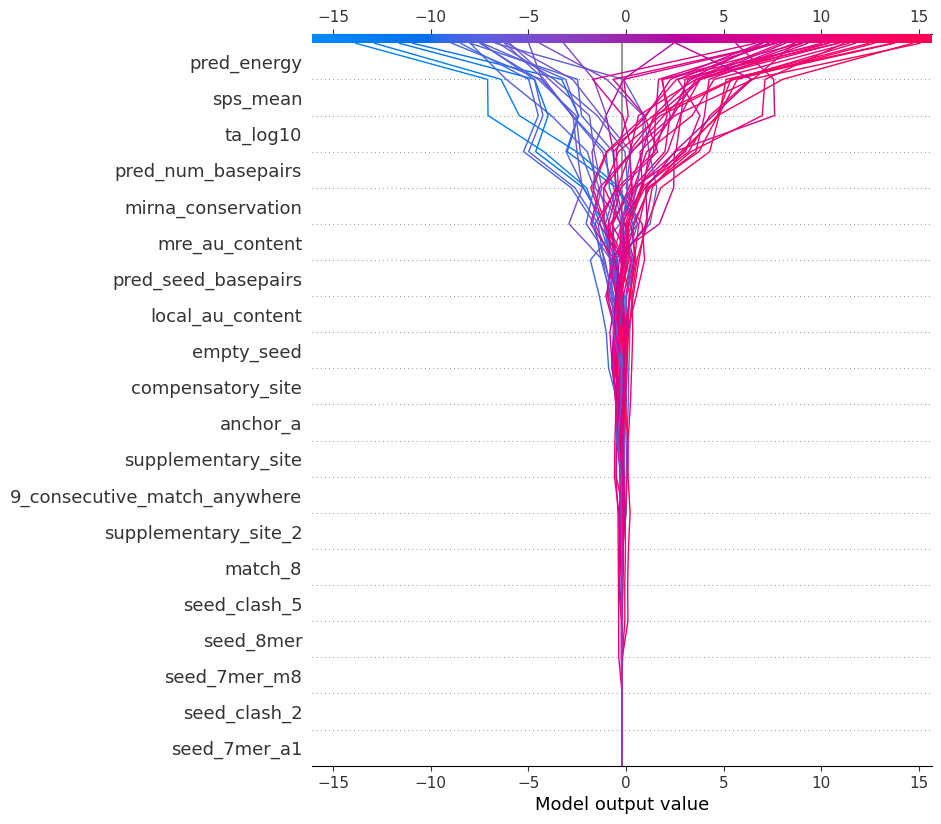

In [14]:
shap.decision_plot(explainer.expected_value, shap_values_after_cv[:50], X_test[:50])

In [15]:
shap.initjs()

In [16]:
shap.force_plot(shap_explanation[0])


In [17]:
df.columns

Index(['pred_energy', 'label', 'pred_num_basepairs', 'pred_seed_basepairs',
       'ta_log10', 'sps_mean', 'anchor_a', '6mer_seed', 'match_8',
       '6mer_seed_1_mismatch', 'compensatory_site', 'supplementary_site',
       'supplementary_site_2', 'empty_seed', '9_consecutive_match_anywhere',
       'mirna_conservation', 'seed_8mer', 'seed_7mer_a1', 'seed_7mer_m8',
       'seed_compensatory', 'seed_clash_2', 'seed_clash_3', 'seed_clash_4',
       'seed_clash_5', 'mre_au_content', 'local_au_content'],
      dtype='object')

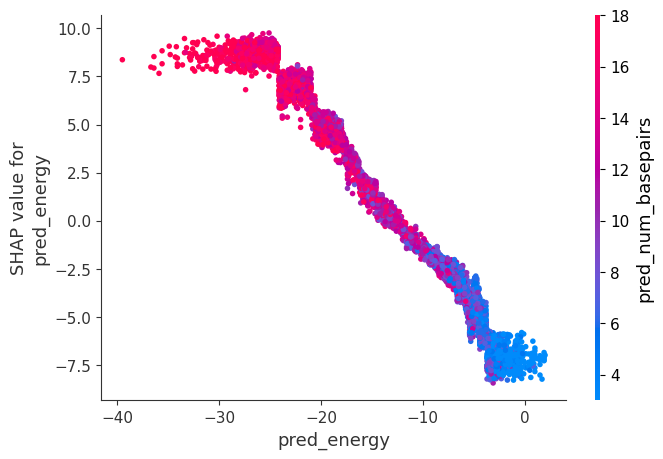

In [18]:
shap.dependence_plot("pred_energy", shap_values_after_cv, X_test, interaction_index="pred_num_basepairs")

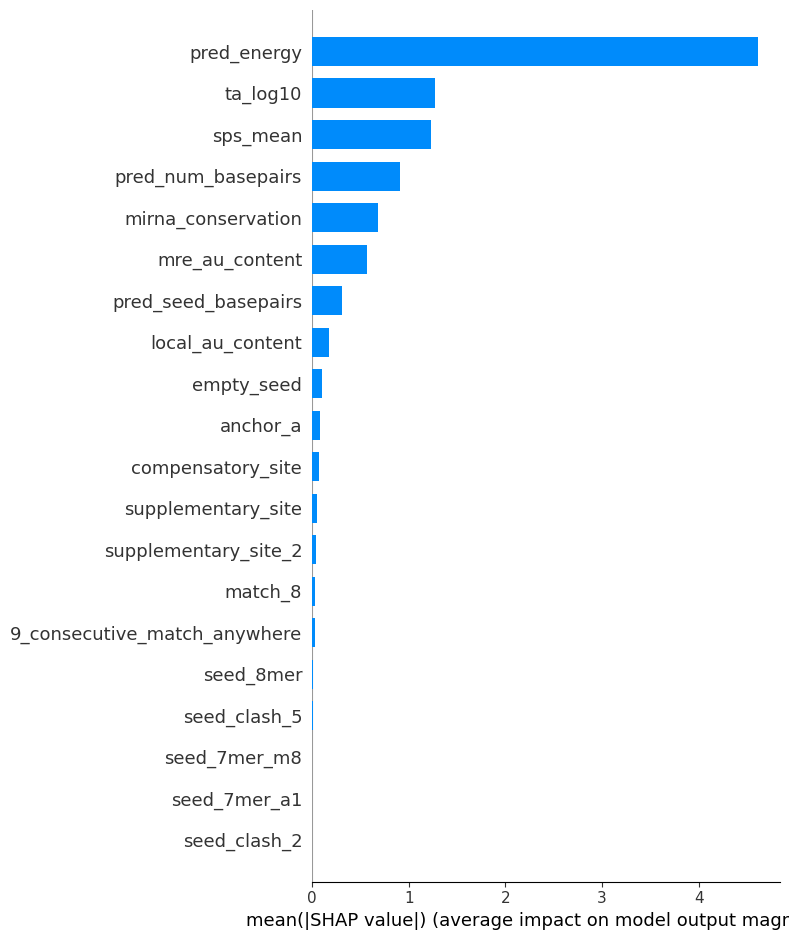

In [19]:
#shap summary plot plotting
import matplotlib.pyplot as pl
shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar", cmap="coolwarm", show=False)
pl.savefig("shap_summary.png",dpi=300) #.png,.pdf will also support here

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


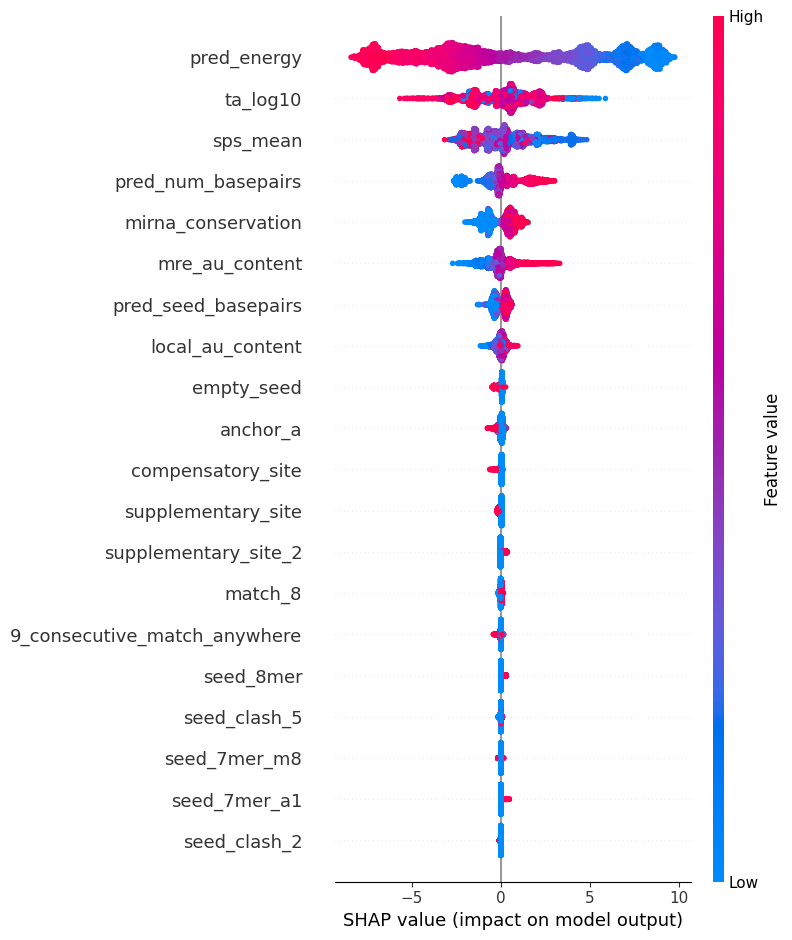

In [20]:
#shap summary plot plotting
import matplotlib.pyplot as pl
shap.summary_plot(shap_values_after_cv, X_test, plot_type="dot", show=False)

pl.savefig("shap_swarm.png",dpi=300) #.png,.pdf will also support here

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


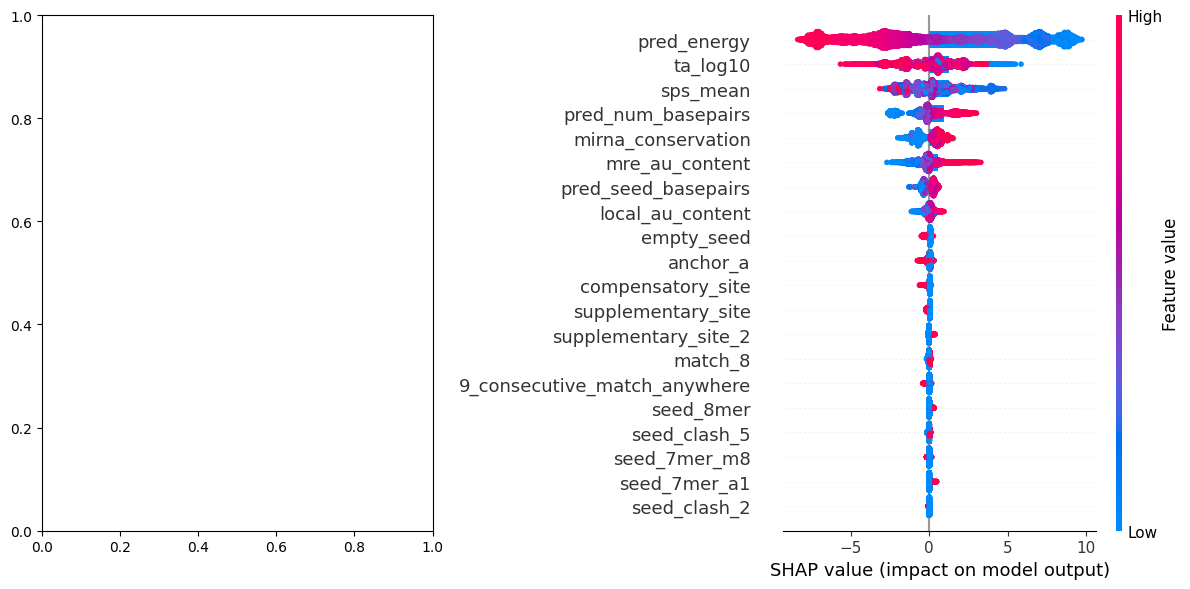

In [21]:
import matplotlib.pyplot as plt

# Create a single figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the first subplot
shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar", show=False, plot_size=None)

# Plot the second subplot
shap.summary_plot(shap_values_after_cv, X_test, plot_type="dot", show=False, plot_size=None)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the combined plot
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


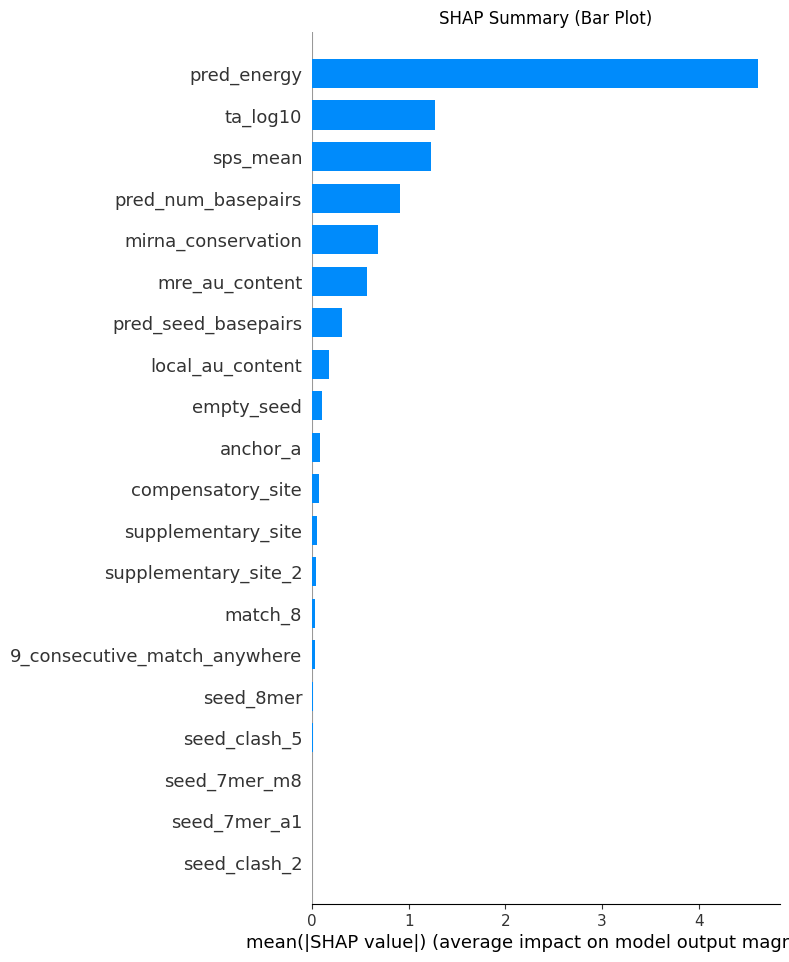

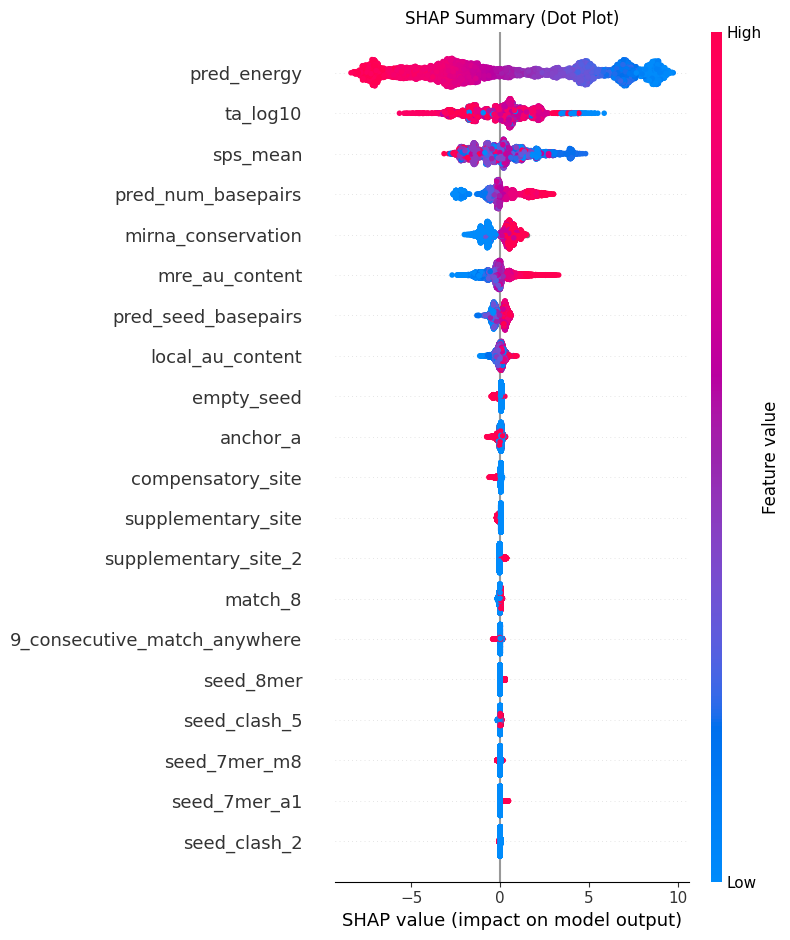

In [22]:


# Create a bar plot
fig1, ax1 = plt.subplots(figsize=(6, 6))
shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar", show=False)
ax1.set_title("SHAP Summary (Bar Plot)")

# Create a dot plot
fig2, ax2 = plt.subplots(figsize=(6, 6))
shap.summary_plot(shap_values_after_cv, X_test, plot_type="dot", show=False)
ax2.set_title("SHAP Summary (Dot Plot)")



# Show the subplots
plt.tight_layout()
plt.show()


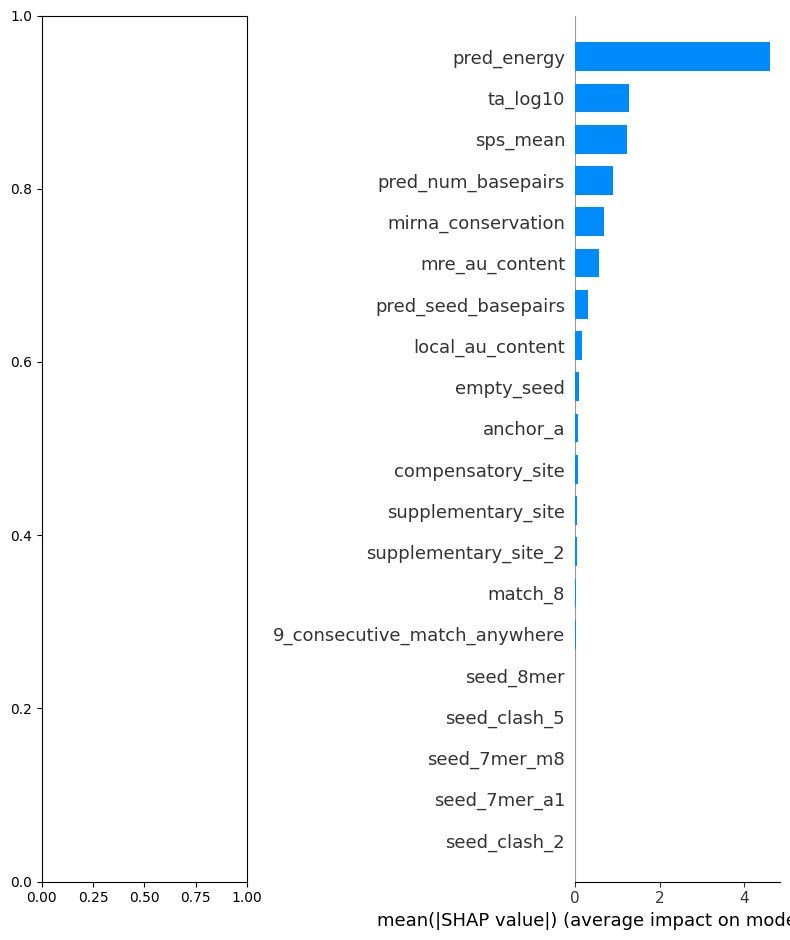

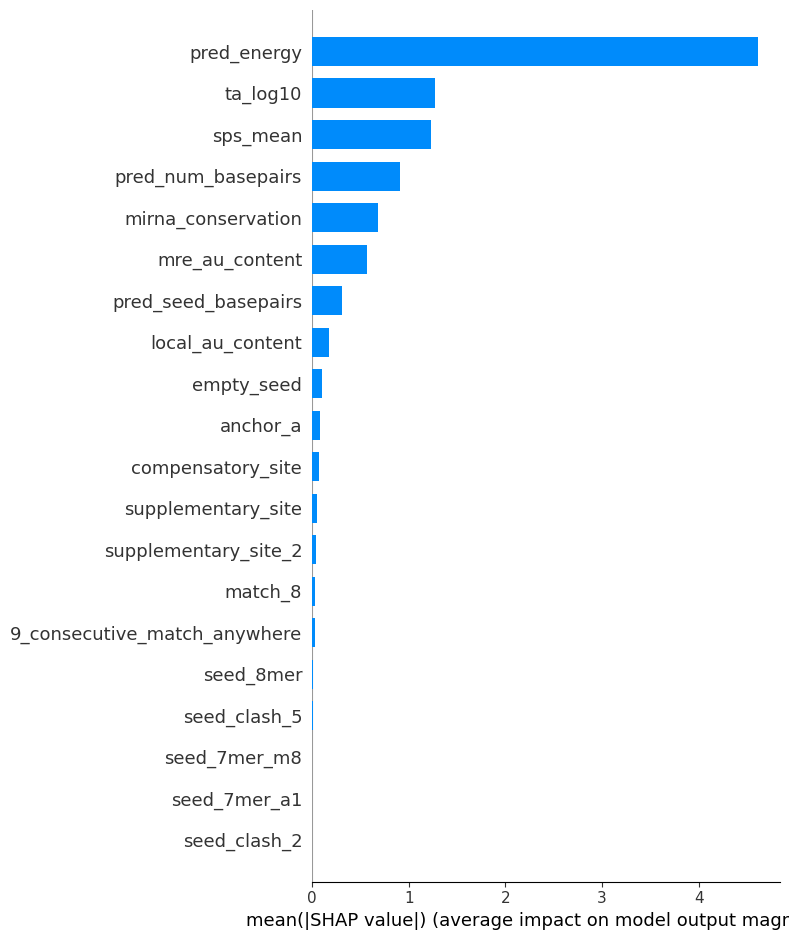

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model_after_cv)
shap_values_after_cv = explainer.shap_values(X_test)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Generate the SHAP summary plot
shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar")

# Get the feature importance values from the SHAP summary plot
summary_values = shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar")

# Generate the bar plot
# Replace feature_name1 and feature_name2 with actual feature names

# Set titles and labels
ax1.set_title("SHAP Summary Plot")
ax2.set_title("Bar Plot")
ax2.set_ylabel("SHAP Value")

# Display the figure
plt.tight_layout()
plt.show()


In [24]:
# Save the trained model
model.save_model('results/model_with_no_close_proximity.json')
model_after_cv.save_model('results/model_with_no_close_proximity_cv.json')


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


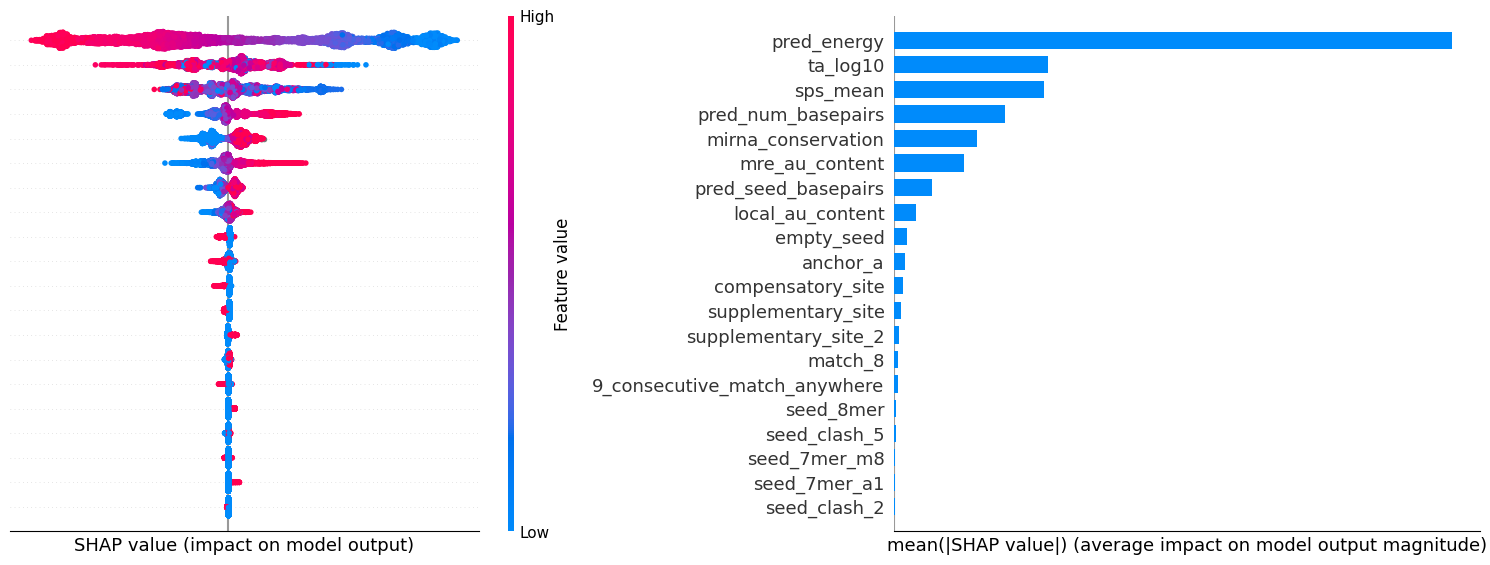

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

# Create a single figure with multiple subplots
fig, axs = plt.subplot_mosaic('AB', figsize=(15, 6))


plt.subplot(1,2,1)
shap.summary_plot(shap_values_after_cv, X_test, plot_type="dot", show=False, plot_size=None)
plt.xticks([])  # Remove x-axis labels
plt.yticks([])  # Remove y-axis labels
y_axis = plt.gca().yaxis

tick_labels = y_axis.get_ticklabels()

# Set the vertical alignment of tick labels to 'center'
for label in tick_labels:
    label.set_verticalalignment('baseline')


plt.subplot(1,2,2)
shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar", show=False, plot_size=None)
plt.xticks([])  # Remove x-axis labels
# plt.yticks([])  # Remove y-axis labels
# plt.gca().invert_xaxis()




# Adjust the spacing between subplots
# plt.tight_layout()

# Display the combined plot
plt.show()
plt.savefig("./asd", bbox_inches='tight', dpi=300)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


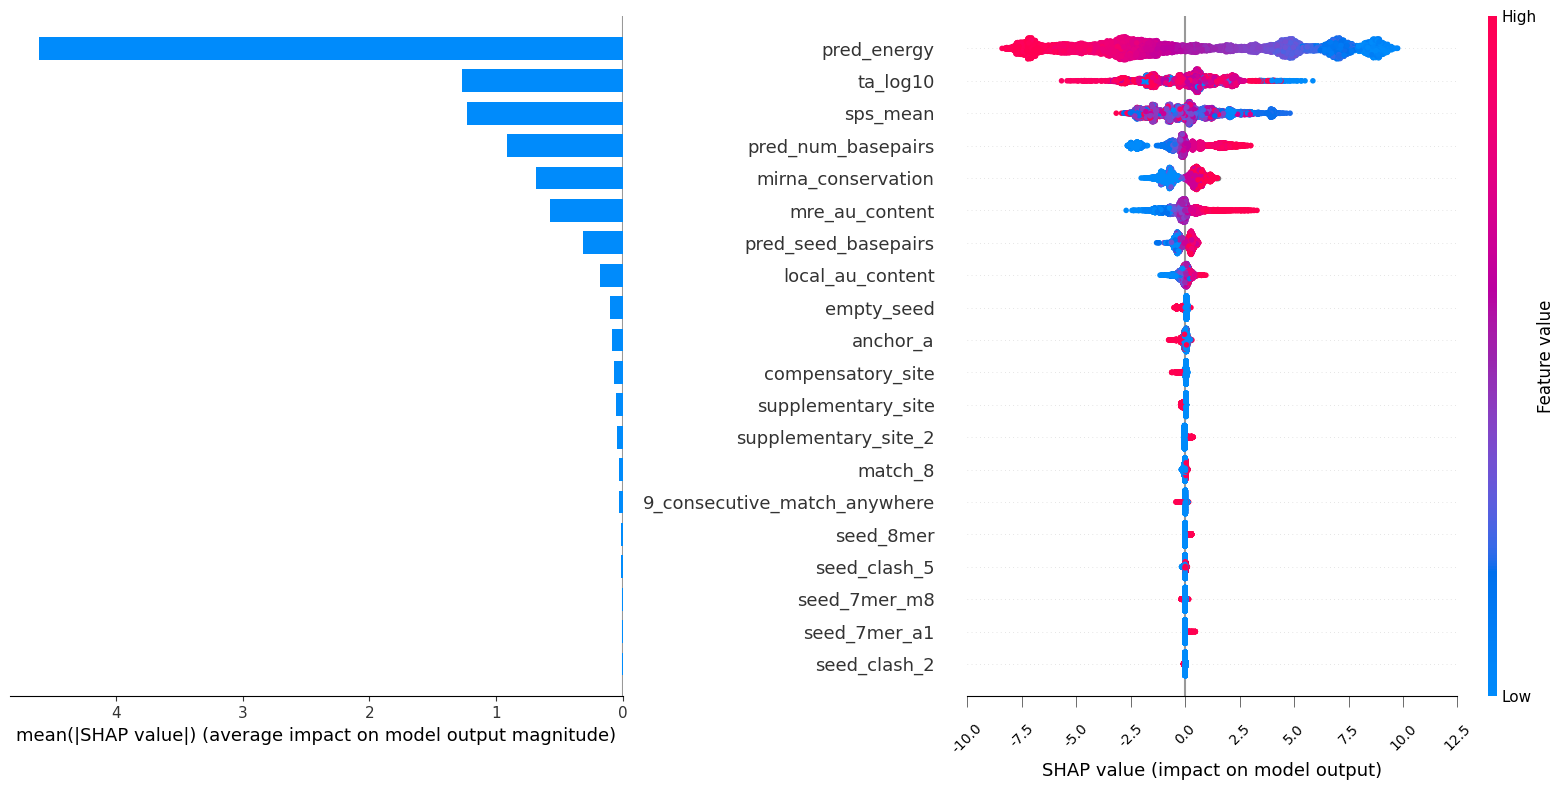

In [26]:
import matplotlib.pyplot as plt

# Create a single figure with multiple subplots
fig, axs = plt.subplot_mosaic('AB', figsize=(16, 8))

plt.subplot(1, 2, 1)
# Assuming you have the necessary imports for shap and other variables
shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar", show=False, plot_size=None)
# plt.xticks([])  # Remove x-axis labels
plt.yticks([])  # Remove y-axis labels
plt.gca().invert_xaxis()



plt.subplot(1, 2, 2)
shap.summary_plot(shap_values_after_cv, X_test, plot_type="dot", show=False, plot_size=None)
# plt.xticks([])  # Remove x-axis labels
# plt.yticks([])  # Remove y-axis labels

# Center-align the x-axis ticks
ax = plt.gca()
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', labelrotation=45, labelsize=10, labelcolor='black', pad=10, width=0.5)
ax.xaxis.set_tick_params(width=0.5, length=8, which='major')
ax.xaxis.set_tick_params(width=0.5, length=4, which='minor')
ax.set_xticklabels(ax.get_xticks(), ha='center')

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig("./asd", bbox_inches='tight', dpi=300)

# Display the combined plot
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


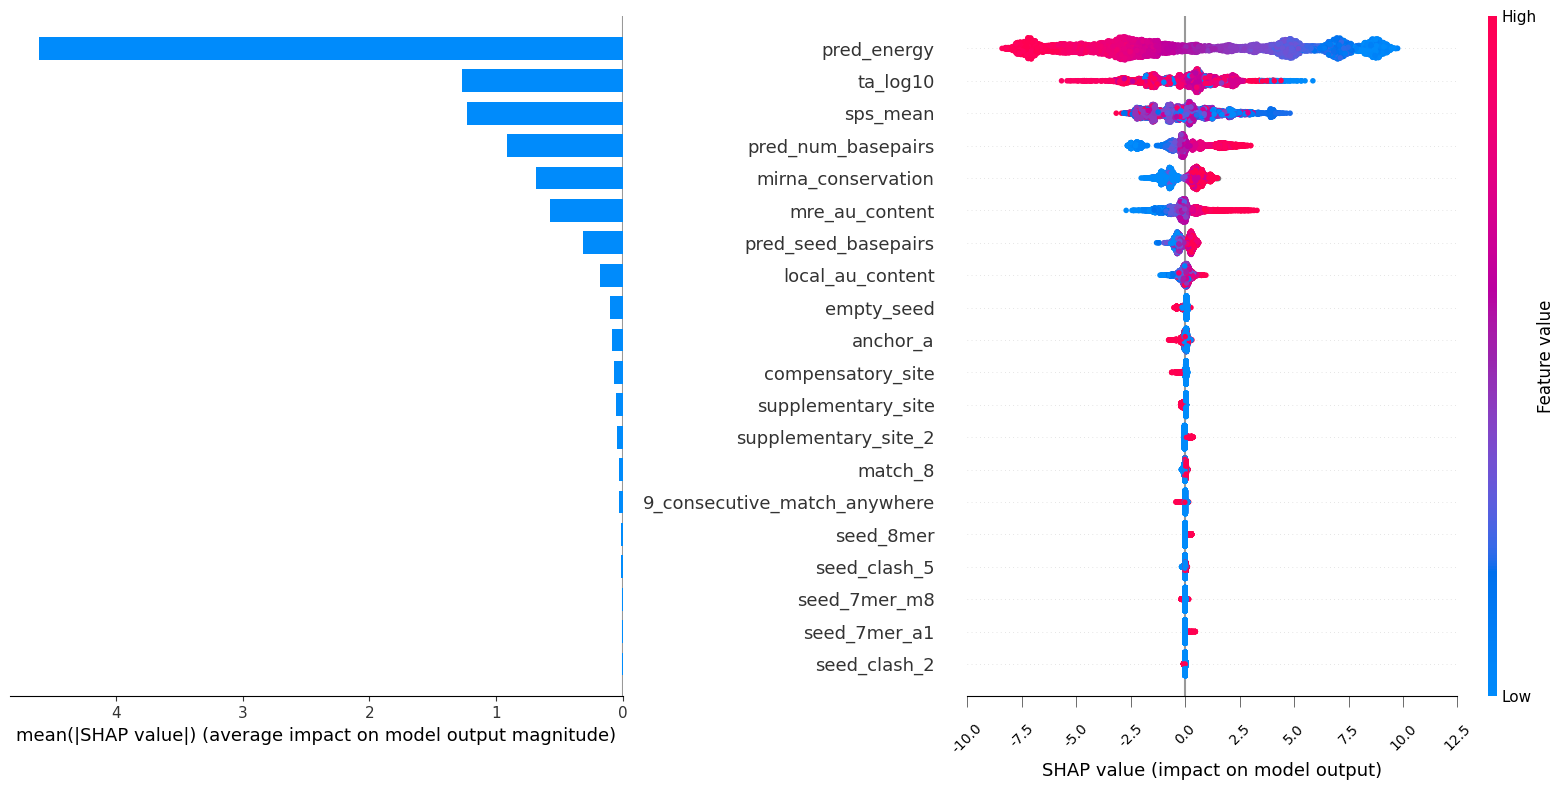

In [32]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# Generate colormap through matplotlib
vapor = LinearSegmentedColormap.from_list("", ['#80D2F2',"#614ED9", '#D977D2'])
friendly = LinearSegmentedColormap.from_list("", ['#785EF0',"#DC267F", '#FE6100'])
newCmap = LinearSegmentedColormap.from_list("", ['#44AA99',"#88CCEE", '#DDCC77'])



import matplotlib.pyplot as plt



# Create a single figure with multiple subplots
fig, axs = plt.subplot_mosaic('AB', figsize=(16, 8))

plt.subplot(1, 2, 1)
# Assuming you have the necessary imports for shap and other variables
shap.summary_plot(shap_values_after_cv, X_test, plot_type="bar", show=False, plot_size=None)
# plt.xticks([])  # Remove x-axis labels
plt.yticks([])  # Remove y-axis labels
plt.gca().invert_xaxis()



plt.subplot(1, 2, 2)
shap.summary_plot(shap_values_after_cv, X_test, plot_type="dot", show=False, plot_size=None)
# plt.xticks([])  # Remove x-axis labels
# plt.yticks([])  # Remove y-axis labels

# Center-align the x-axis ticks
ax = plt.gca()
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', labelrotation=45, labelsize=10, labelcolor='black', pad=10, width=0.5)
ax.xaxis.set_tick_params(width=0.5, length=8, which='major')
ax.xaxis.set_tick_params(width=0.5, length=4, which='minor')
ax.set_xticklabels(ax.get_xticks(), ha='center')

# Adjust the spacing between subplots
plt.tight_layout()
# plt.savefig("./asd", bbox_inches='tight', dpi=300)

# Display the combined plot
plt.show()


In [35]:
shap_values.feature_names


AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

In [33]:
df.columns

Index(['pred_energy', 'label', 'pred_num_basepairs', 'pred_seed_basepairs',
       'ta_log10', 'sps_mean', 'anchor_a', '6mer_seed', 'match_8',
       '6mer_seed_1_mismatch', 'compensatory_site', 'supplementary_site',
       'supplementary_site_2', 'empty_seed', '9_consecutive_match_anywhere',
       'mirna_conservation', 'seed_8mer', 'seed_7mer_a1', 'seed_7mer_m8',
       'seed_compensatory', 'seed_clash_2', 'seed_clash_3', 'seed_clash_4',
       'seed_clash_5', 'mre_au_content', 'local_au_content'],
      dtype='object')